# Transform Demand data, so it can be used by a Neural Network


In [1]:
import datetime
import pandas as pd
import nltk
import numpy as np
import random

from feature_engine.creation import CyclicalFeatures
from nltk.corpus import wordnet
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from typing import Tuple

In [2]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/uclm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from src.robin.supply.entities import Supply

path_config_supply = '../configs/test_case/supply_data.yml'

supply = Supply.from_yaml(path_config_supply)

# Get set of corridors
corridors = []
for service in supply.services:
    if service.line.corridor not in corridors:
        corridors.append(service.line.corridor)

# Get set of paths
paths = []
for corridor in corridors:
    for path in corridor.paths:
        if path not in paths:
            paths.append(path)

# Parse paths of Station objects to paths of station mame
paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [4]:
def get_word_syn(word: str) -> str:
    """
    Get a random synonym of a word

    Args:
        word (str): Word to get the synonym from

    Returns:
        str: Synonym of the word
    """
    word_synset = wordnet.synsets(word)
    if len(word_synset) > 0:
        station_synset = word_synset[0]
        station_lemmas = station_synset.lemmas()
        if len(station_lemmas) > 0:
            word_lemma = random.choice(station_lemmas)
            return word_lemma.name().lower()

    return word

def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [5]:
stations_csv_path = f'../data/renfe/renfe_stations.csv'

def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [6]:
n_passengers = 10000

pairs = []
for _ in range(n_passengers):
    pairs.append(get_random_pair(paths))

df = pd.DataFrame(pairs, columns=['origin', 'destination'])

user_patterns = ("business", "student", "tourist")

df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

random_timedelta = lambda: datetime.timedelta(days=random.randint(0, 365*10), hours=random.randint(0, 24), minutes=random.randint(0, 60))
df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
print(df.head())

df_time = pd.DataFrame()
df_time['year'] = df['arrival_date'].apply(lambda x: x.year)
df_time['month'] = df['arrival_date'].apply(lambda x: x.month)
df_time['day'] = df['arrival_date'].apply(lambda x: x.day)
df_time['hour'] = df['arrival_date'].apply(lambda x: x.hour)
df_time['minute'] = df['arrival_date'].apply(lambda x: x.minute)

scaler = MinMaxScaler()
df_time['year'] = scaler.fit_transform(df_time['year'].to_numpy().reshape(-1, 1))

cyclical = CyclicalFeatures(variables=['month', 'day', 'hour', 'minute'], drop_original=True)
df_time = cyclical.fit_transform(df_time)

print(df_time.head())

        origin destination user_pattern        arrival_date
0     zaragoza   barcelona     business 2028-01-08 11:38:00
1       lleida   tarragona      student 2024-02-03 20:56:00
2       madrid   barcelona     business 2030-02-24 05:12:00
3    tarragona      girona     business 2026-02-01 06:29:00
4  guadalajara    zaragoza      tourist 2029-06-08 07:15:00
       year     month_sin  month_cos   day_sin   day_cos  hour_sin  hour_cos  \
0  0.777778  5.000000e-01   0.866025  0.998717 -0.050649  0.136167 -0.990686   
1  0.333333  8.660254e-01   0.500000  0.571268  0.820763 -0.730836  0.682553   
2  1.000000  8.660254e-01   0.500000 -0.988468  0.151428  0.979084  0.203456   
3  0.555556  8.660254e-01   0.500000  0.201299  0.979530  0.997669 -0.068242   
4  0.888889  1.224647e-16  -1.000000  0.998717 -0.050649  0.942261 -0.334880   

   minute_sin  minute_cos  
0   -0.786552   -0.617525  
1   -0.314077    0.949398  
2    0.957422    0.288692  
3    0.053222   -0.998583  
4    0.999646   -0.

In [7]:
# Get bag of words
words_set = set(df[['origin', 'destination', 'user_pattern', ]].values.flatten())

print(words_set)

{'tarragona', 'zaragoza', 'girona', 'student', 'madrid', 'figueres', 'calatayud', 'tourist', 'business', 'lleida', 'guadalajara', 'barcelona'}


In [8]:
# Import GloVe embeddings 50D
import os
import numpy as np

EMBEDDING_DIM = 50

word_index = {word: index for index, word in enumerate(words_set)}

embeddings_index = {}
f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype=np.float32)
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
embedding_dict = {}
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    print(word, embedding_vector)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embedding_dict[word] = embedding_vector

Found 400000 word vectors.
tarragona [ 1.3885   -0.089092 -1.0508    0.058438 -0.50411  -0.80545   0.80153
  0.82715  -1.2087    0.45195   0.80519  -1.5551    0.34254  -0.75674
  0.028514 -0.10778  -0.059228  0.51951  -0.45246   0.96256  -0.94067
 -0.78372  -0.36429   1.6069   -1.3246    0.48912   0.53017   0.53761
  0.4855    0.50803  -0.27815   0.77234  -1.4666   -0.45942   0.26933
  0.33678  -0.36631   1.0428    0.7383    0.42628   0.67481  -0.16776
  0.2546   -0.8961   -0.65298   0.98143   0.46095  -0.030374  0.9039
 -0.36815 ]
zaragoza [ 1.0642    0.089939 -0.28715   0.82471   0.31063  -1.4798    0.12028
  0.7449   -1.2919    0.39737   0.4715   -0.53483  -0.48049  -1.2998
  0.32826  -1.3085   -0.67916  -0.20625  -0.7232    0.41638  -1.2895
 -0.69963  -0.23631   0.70175  -0.61498   0.20193   1.329     0.25294
 -0.093715 -0.16535   0.99605   1.2007   -0.26729  -0.42035  -0.15881
  0.63906  -0.73977   1.3119    0.61136  -0.59197   1.3032    0.16094
 -0.027686 -0.9412   -0.68288   0.6

In [9]:
df_embedding = pd.DataFrame()
df_embedding['origin'] = df['origin'].apply(lambda x: embedding_dict.get(x))
df_embedding['destination'] = df['destination'].apply(lambda x: embedding_dict.get(x))
df_embedding['user_pattern'] = df['user_pattern'].apply(lambda x: embedding_dict.get(x))
df_embedding['scaled_date'] = df_time.values.tolist()
df_embedding['scaled_date'] = df_embedding['scaled_date'].apply(lambda x: np.asarray(x + [0.0] * (EMBEDDING_DIM - len(x)), dtype=np.float32))
df_embedding = df_embedding[['origin', 'destination', 'user_pattern', 'scaled_date']]

input_data = df_embedding[['origin', 'destination', 'user_pattern', 'scaled_date']].values.tolist()
input_vectors = np.array([np.asarray(row, dtype=np.float32) for row in input_data])

print(input_vectors.shape)

(10000, 4, 50)


## Embedding Model

In [10]:
import keras.backend as K

from keras.layers import Layer
from keras.utils.generic_utils import get_custom_objects


class SampleLayer(Layer):
    @property
    def name(self):
        return self._name

    def __init__(self, gamma, capacity, name, **kwargs):
        super(SampleLayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.max_capacity = capacity
        self.name = name

    def build(self, input_shape):
        super(SampleLayer, self).build(input_shape)
        self.built = True

    def call(self, layer_inputs, **kwargs):
        if len(layer_inputs) != 2:
            raise Exception('input layers must be a list: mean and stddev')
        if len(K.int_shape(layer_inputs[0])) != 2 or len(K.int_shape(layer_inputs[1])) != 2:
            raise Exception('input shape is not a vector [batchSize, latentSize]')

        mean = layer_inputs[0]
        log_var = layer_inputs[1]

        batch = K.shape(mean)[0]
        dim = K.int_shape(mean)[1]

        latent_loss = -0.5 * (1 + log_var - K.square(mean) - K.exp(log_var))
        latent_loss = K.sum(latent_loss, axis=1, keepdims=True)
        latent_loss = K.mean(latent_loss)
        latent_loss = self.gamma * K.abs(latent_loss - self.max_capacity)

        latent_loss = K.reshape(latent_loss, [1, 1])

        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        layer_output = mean + K.exp(0.5 * log_var) * epsilon

        self.add_loss(losses=[latent_loss], inputs=[layer_inputs])

        return layer_output

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = {
            'gamma': self.gamma,
            'capacity': self.max_capacity,
            'name': self.name
        }
        base_config = super(SampleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @name.setter
    def name(self, value):
        self._name = value


get_custom_objects().update({'SampleLayer': SampleLayer})

2023-05-12 10:56:04.360167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
"""Module for implementing time to vector encoding"""

# Source: https://gist.github.com/Anuj040/9402d433e0c7f1625f0af737ff03a02d

import tensorflow as tf
from tensorflow.keras.layers import Layer

class Time2Vec(Layer):
    """Time2Vector encoding layer"""

    def __init__(self, kernel: int = 64, activation: str = "sin") -> None:
        """
        Args:
            kernel (int, optional): length of time vector representation. Defaults to 64
            activation (str, optional): periodic activation for time encoding. Defaults to "sin".
        Raises:
            NotImplementedError: Non-supported activations
        """
        # periodic components
        if activation in ["sin", "cos"]:
            activation = {"sin": tf.math.sin, "cos": tf.math.cos}[activation]
        else:
            raise NotImplementedError(
                f"'{activation}' is an unsupported periodic activation."
            )

        super().__init__(trainable=True, name="Time2VecLayer_" + activation.__name__)

        self.k = kernel - 1
        self.p_activation = activation

    def build(self, input_shape: tuple) -> None:
        """method for building and initializing the weights for the tensor operations
        Args:
            input_shape (tuple): shape of the incoming tensor
        """
        # Linear component
        self.w_b = self.add_weight(
            shape=(1, input_shape[1], 1), initializer="uniform", trainable=True
        )

        self.b_b = self.add_weight(
            shape=(1, input_shape[1], 1), initializer="uniform", trainable=True
        )

        # Periodic components
        self.freq = self.add_weight(
            shape=(1, input_shape[1], self.k), initializer="uniform", trainable=True
        )

        self.phase = self.add_weight(
            shape=(1, input_shape[1], self.k), initializer="uniform", trainable=True
        )

        super().build(input_shape)

    def call(self, inputs: tf.Tensor, **kwargs) -> tf.Tensor:
        """method to perform the layer operation
        Args:
            inputs (tf.Tensor): shape = (batch_size, feature_size)
        Returns:
            tf.Tensor: shape = (batch_size, feature_size, length of time vector representation)
        """
        inputs = tf.expand_dims(inputs, axis=-1)

        # Linear components
        lin = (
            # Multiply each time dimension with the corresponding linear time component
            tf.multiply(inputs, self.w_b)
            # Bias component for each time dimension
            + self.b_b
        )

        # Periodic components
        # Multiply each time dimension (M, D, H, mins, etc.) with the corresponding frequency vector
        per = tf.multiply(tf.tile(inputs, multiples=[1, 1, self.k]), self.freq)
        # Phase vector for each time dimension
        per = self.p_activation(per + self.phase)
        return tf.concat([lin, per], -1)

    def compute_output_shape(self, input_shape: tuple) -> tuple:
        """computes the shape of output tensor
        Args:
            input_shape (tuple): shape of incoming tensor
        Returns:
            tuple: shape of outgoing tensor
        """
        return (input_shape[0], input_shape[1], self.k + 1)


if __name__ == "__main__":
    test_vector = scaled_date
    print(test_vector)

    xti = Time2Vec(50, "sin")(test_vector)
    print(xti.shape)

2023-05-11 19:20:46.089991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'scaled_date' is not defined

In [11]:
from keras.models import Sequential
from keras.layers import Input, Embedding, Flatten

vocab_size = len(words_set)

embedding_model = Sequential()
embedding_model.add(Input(shape=(3,)))
embedding_model.add(Embedding(input_dim= vocab_size + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            name='words_embedding', trainable=True
                            ))

embedding_model.compile(optimizer='adam', loss='mse')
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 words_embedding (Embedding)  (None, 3, 50)            650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


2023-05-12 10:56:21.381064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Autoencoder model

In [13]:
import tensorflow as tf

from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model

input_shape = (4, EMBEDDING_DIM)
output_shape = (4, EMBEDDING_DIM)

latent_dim = 4

inputs = Input(shape=input_shape)

encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

z_dim = 4
vae_gamma = 100
vae_capacity = 5
dense1 = Dense(4)(encoder)
x = Dense(units=z_dim * 2, activation='linear')(dense1)

# Beta-VAE implementation as follows
z_mean = Dense(units=z_dim, activation='linear', name='sample_mean')(dense1)
z_log_var = Dense(units=z_dim, activation='linear', name='sample_log_var')(x)
embed_layer = SampleLayer(gamma=vae_gamma, capacity=vae_capacity, name='sampling_layer')([z_mean, z_log_var])

decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

encoder_model = Model(inputs, embed_layer)
decoder_model = Model(decoder_inputs, decoder_outputs)

model = Model(inputs, decoder_model(embed_layer))

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 gru_4 (GRU)                    (None, 4, 64)        22272       ['input_4[0][0]']                
                                                                                                  
 gru_5 (GRU)                    (None, 32)           9408        ['gru_4[0][0]']                  
                                                                                                  
 dense_3 (Dense)                (None, 4)            132         ['gru_5[0][0]']                  
                                                                                            

In [14]:
history = model.fit(input_vectors, input_vectors, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


ValueError: in user code:

    File "/Users/david/opt/anaconda3/envs/robin/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/david/opt/anaconda3/envs/robin/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/david/opt/anaconda3/envs/robin/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/david/opt/anaconda3/envs/robin/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/david/opt/anaconda3/envs/robin/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/david/opt/anaconda3/envs/robin/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 316, in __call__
        total_total_loss_mean_value = tf.add_n(total_loss_mean_values)

    ValueError: Shapes must be equal rank, but are 0 and 2
    	From merging shape 0 with other shapes. for '{{node AddN}} = AddN[N=2, T=DT_FLOAT](mean_squared_error/weighted_loss/value, model_2/sampling_layer/Reshape)' with input shapes: [], [1,1].


## Plot history

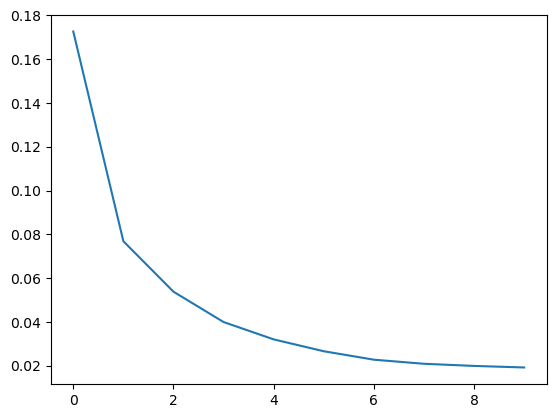

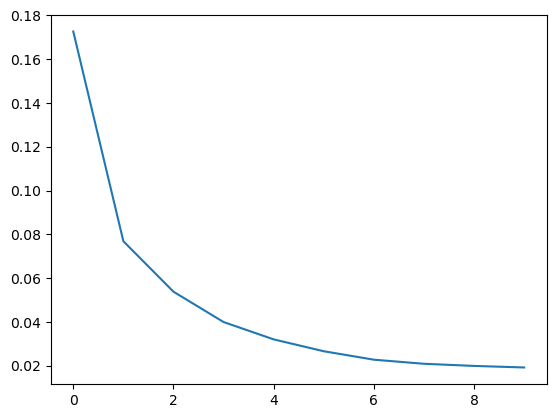

In [17]:
# Plot history loss and mse

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.show()
plt.plot(history.history['mean_squared_error'], label='mse')
plt.show()

## Make predictions

In [18]:
def find_closest_embeddings(embedding, embedding_dict):
    return sorted(embedding_dict.keys(), key=lambda word: spatial.distance.euclidean(embedding_dict[word], embedding))[0]

In [35]:
random_index = np.random.randint(0, len(input_vectors))
random_vector = input_vectors[random_index]

print("Input - Random passenger data: ")
print(df.iloc[random_index])

prediction = model.predict(np.array([random_vector]))[0]

print("Output - Passenger reconstruction: ")
decoded_prediction = [find_closest_embeddings(word_vector, embedding_dict) for word_vector in prediction[:3]]
print(decoded_prediction)
predicted_year = scaler.inverse_transform(np.array([prediction[-1][:1]]))
print(int(predicted_year[0][0]))



Input - Random passenger data: 
origin                     zaragoza
destination                  girona
user_pattern                tourist
arrival_date    2030-07-19 09:41:00
Name: 9867, dtype: object
1/1 [==============================] - 0s 17ms/step
Output - Passenger reconstruction: 
['zaragoza', 'girona', 'tourist']
2025
